# Health factchecker 


We are using the dataset provided by Enyan Dai in [FakeHealth](https://github.com/EnyanDai/FakeHealth), which contains health articles rated from 0 (mostly or totally fake) to 5 (mostly or totally true). The dataset was originally crafted to supplement the paper [Ginger Cannot Cure Cancer: Battling Fake Health News with a Comprehensive Data Repository](https://arxiv.org/abs/2002.00837) by Dai, Sun and Wang (2020). Additionally, it was also used by Kumari et al. (2021) in the paper [Debunking health fake news with domain specific pre-trained model](https://www.sciencedirect.com/science/article/pii/S2666285X21000662).

## Data

In [1]:
# warnings
import warnings

# data
import numpy as np
import pandas as pd

# plotting
import seaborn as sns

# preprocessing
import nltk
import re

# algorithms
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# nltk requirements
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ignore warnings
warnings.filterwarnings('ignore')

# create dataset
dataset = pd.read_csv('../data/fake-health.csv', index_col=0)

[nltk_data] Downloading package punkt to /home/mer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# show dataset
dataset.head(5)

,headline,author,source,original title,link,text,rating
0,Implantable device ‘aids weight loss’? Let’s w...,[],University of Wisconsin-Madison,Tiny implantable device short-circuits hunger ...,https://www.healthnewsreview.org/news-release-...,"MADISON, Wis. -- More than 700 million adults ...",2
1,Summary of CRISPR lung cancer research downpla...,[],Christiana Care Health System,Scientists report CRISPR restores effectivenes...,https://www.healthnewsreview.org/news-release-...,"Wilmington, DE, December 17, 2018 - The CRISPR...",3
2,‘Millions’ with bipolar disorder could be help...,[],American College of Neuropsychophamacology,Probiotics could help millions of patients suf...,https://www.healthnewsreview.org/news-release-...,About 3 million people in the US are diagnosed...,1
3,Summary of dairy-enhanced Mediterranean diet s...,[],University of South Australia,Yes Please to Yogurt and Cheese: The New Impro...,https://www.healthnewsreview.org/news-release-...,Newswise — Thousands of people can take heart ...,1
4,Johns Hopkins prematurely heralds a ‘promising...,[],Johns Hopkins Medicine,Johns Hopkins team identifies promising diagno...,https://www.healthnewsreview.org/news-release-...,Researchers at Johns Hopkins Medicine have ide...,3


<AxesSubplot:xlabel='rating', ylabel='count'>

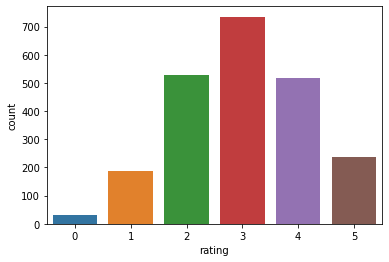

In [3]:
# plot by rating
sns.countplot(dataset.rating)

In [4]:
# new dataset with article content and rating only
rated_content = dataset[['text', 'rating']].copy()

# change rating from 0-5 to 0-1
rated_content.rating = rated_content.rating.apply(lambda r: 0 if r<4 else 1)

## Preprocessing

In [5]:
def clean(text):
    """
    Transforms text to lower case and removes html tags, punctuation
    marks, symbols and numbers.
    
    Parameters
    ----------
    text : str
        Text to clean.
        
    Returns
    -------
    text : str
        Clean text.
    """
    
    text = str(text)
    text = text.lower()
    
    # html tags
    text = re.sub(r'<.*?>',' ',text) 
    # punctuation marks
    text = re.sub(r'[^A-Za-z ]+', '', text)
    
    return text

### Text cleaning

In [6]:
# clean text
rated_content.text = rated_content.text.apply(lambda t: clean(t))

# copy of the unclean dataset
unclean_rated_content = rated_content.copy()

# remove duplicates
rated_content = rated_content.drop_duplicates(subset='text')

print('Number of duplicated articles removed: {}'.format(len(unclean_rated_content)-len(rated_content)))

Number of duplicated articles removed: 77


### Tokenization and lemmatizacion

In [7]:
# tokenize
rated_content.text = rated_content.text.apply(lambda t: nltk.word_tokenize(str(t)))


stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

# lemmatize
rated_content.text = rated_content.text.apply(lambda ws: [lemmatizer.lemmatize(w) for w in ws if w not in stopwords])

### Back to text

In [8]:
rated_content.text = rated_content.text.apply(lambda t: ' '.join(t))

## Model

### Train and test sets

In [9]:
x = rated_content.text
y = rated_content.rating

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

### Multinomial Naive Bayes

In [17]:
mnb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('mnb', MultinomialNB())])

mnb.fit(x_train, y_train)

mb_pred = mnb.predict(x_test)

print('Accuracy: {}'.format(accuracy_score(y_test, mb_pred)))
print('Classification report: \n{}'.format(classification_report(y_test, mb_pred)))

Accuracy: 0.7129629629629629
Classification report: 
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       308
           1       0.00      0.00      0.00       124

    accuracy                           0.71       432
   macro avg       0.36      0.50      0.42       432
weighted avg       0.51      0.71      0.59       432

